In [1]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [2]:
# Create Tensors to hold input and outputs.

beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,-8]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,4]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,6]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0
prior=0

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

x= torch.cat((x1,x2), dim=0)
x= torch.cat((x,x3), dim=0)

y= torch.cat((y1,y2), dim=0)
y= torch.cat((y,y3), dim=0)

train_x, test_x, train_y, test_y= train_test_split(x,y, test_size=0.2, random_state=1)




In [4]:
train_x.shape

torch.Size([480, 100])

In [5]:
# switch training set
inputs,targets = train_x,train_y

# switching testing set
test_inputs, test_targets = test_x,test_y

In [6]:
################## first step##################

# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs):
        lambda1,lambda2 = config["lambda1"], config["lambda2"]
        model=MLP(seed=1)
        max_iteration=1000
        learning_rate=0.6
        params_to_optimize=list(model.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out, layer1_out, layer2_out,layer3_out= model(inputs[idx_train])


            # extract parameters
            #[:-1] for leaving out bias term#
            model_all_linear1_params = model.linear1
            model_all_linear2_params= torch.cat([x.view(-1) for x in model.linear2.parameters()][:-1])
            model_all_linear3_params= torch.cat([x.view(-1) for x in model.linear3.parameters()][:-1])
            model_all_linear4_params= torch.cat([x.view(-1) for x in model.linear4.parameters()][:-1])
           
    
            # compute loss
            all_linear1_params=model_all_linear1_params.reshape(1,-1)
            all_linear234_params=torch.cat((model_all_linear2_params,model_all_linear3_params, model_all_linear4_params),0)

            BCE_loss = loss_fn(out, targets[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out, test_layer1_out, test_layer2_out,test_layer3_out= model(train_x[idx_test])
        
        test_BCE_loss = loss_fn(test_out, targets[idx_test].reshape(-1,1))
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs,targets = train_x,train_y

    
    config={
        "lambda1": tune.choice([0.01,0.02,0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003])
    }
    #config={
    #    "lambda1": tune.choice([0.05,0.1,0.6]),
    #    "lambda2": tune.choice([0.0001,0.0002,0.0003, 0.0004,0.0005])
    #}

    result = tune.run(
        train_model,  
        config=config,
        num_samples=20)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


2022-10-03 16:16:47,901	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2022-10-03 16:16:48,833	WARNING function_trainable.py:619 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2022-10-03 16:16:48,855	INFO tensorboardx.py:170 -- pip install "ray[tune]" to see TensorBoard files.
2022-10-03 16:16:48,856	WARNING callback.py:108 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,status,loc,lambda1,lambda2,iter,total time (s),my_test_BCE_loss
train_model_ba4ea_00000,TERMINATED,10.224.0.12:14337,0.04,0.003,1,5.13594,0.68251
train_model_ba4ea_00001,TERMINATED,10.224.0.12:14362,0.05,0.001,1,5.33417,0.68046
train_model_ba4ea_00002,TERMINATED,10.224.0.12:14363,0.04,0.003,1,5.52919,0.68251
train_model_ba4ea_00003,TERMINATED,10.224.0.12:14364,0.01,0.002,1,6.32127,1.59768
train_model_ba4ea_00004,TERMINATED,10.224.0.12:14365,0.04,0.002,1,6.2351,0.678405
train_model_ba4ea_00005,TERMINATED,10.224.0.12:14366,0.03,0.003,1,6.41968,0.706058
train_model_ba4ea_00006,TERMINATED,10.224.0.12:14367,0.02,0.001,1,4.9335,0.977871
train_model_ba4ea_00007,TERMINATED,10.224.0.12:14368,0.04,0.003,1,5.85298,0.68251
train_model_ba4ea_00008,TERMINATED,10.224.0.12:14369,0.03,0.002,1,5.60049,0.719141
train_model_ba4ea_00009,TERMINATED,10.224.0.12:14370,0.04,0.003,1,5.64918,0.68251


Result for train_model_ba4ea_00000:
  date: 2022-10-03_16-16-56
  done: false
  experiment_id: e0da34b897374503b4813b8effa9b6e0
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 0.682509982585907
  node_ip: 10.224.0.12
  pid: 14337
  time_since_restore: 5.135942459106445
  time_this_iter_s: 5.135942459106445
  time_total_s: 5.135942459106445
  timestamp: 1664785016
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ba4ea_00000
  warmup_time: 0.02561187744140625
  
Result for train_model_ba4ea_00000:
  date: 2022-10-03_16-16-56
  done: true
  experiment_id: e0da34b897374503b4813b8effa9b6e0
  experiment_tag: 0_lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 0.682509982585907
  node_ip: 10.224.0.12
  pid: 14337
  time_since_restore: 5.135942459106445
  time_this_iter_s: 5.135942459106445
  time_total_s: 5.135942459106445
  timestamp: 1664785016
  timesteps_since_restore: 0
  train

Result for train_model_ba4ea_00018:
  date: 2022-10-03_16-16-58
  done: false
  experiment_id: bcea124ac23346d7be95ab3fc7ed3ec8
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 0.6804596424102783
  node_ip: 10.224.0.12
  pid: 14379
  time_since_restore: 5.0237298011779785
  time_this_iter_s: 5.0237298011779785
  time_total_s: 5.0237298011779785
  timestamp: 1664785018
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ba4ea_00018
  warmup_time: 0.0033211708068847656
  
Result for train_model_ba4ea_00018:
  date: 2022-10-03_16-16-58
  done: true
  experiment_id: bcea124ac23346d7be95ab3fc7ed3ec8
  experiment_tag: 18_lambda1=0.0500,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 0.6804596424102783
  node_ip: 10.224.0.12
  pid: 14379
  time_since_restore: 5.0237298011779785
  time_this_iter_s: 5.0237298011779785
  time_total_s: 5.0237298011779785
  timestamp: 1664785018
  timesteps_since_restore

Result for train_model_ba4ea_00004:
  date: 2022-10-03_16-16-59
  done: false
  experiment_id: bbcb092de14248b0a76fa4f395fe94c1
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 0.6784050107002259
  node_ip: 10.224.0.12
  pid: 14365
  time_since_restore: 6.235098361968994
  time_this_iter_s: 6.235098361968994
  time_total_s: 6.235098361968994
  timestamp: 1664785019
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ba4ea_00004
  warmup_time: 0.0033829212188720703
  
Result for train_model_ba4ea_00004:
  date: 2022-10-03_16-16-59
  done: true
  experiment_id: bbcb092de14248b0a76fa4f395fe94c1
  experiment_tag: 4_lambda1=0.0400,lambda2=0.0020
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 0.6784050107002259
  node_ip: 10.224.0.12
  pid: 14365
  time_since_restore: 6.235098361968994
  time_this_iter_s: 6.235098361968994
  time_total_s: 6.235098361968994
  timestamp: 1664785019
  timesteps_since_restore: 0
  t

2022-10-03 16:16:59,911	INFO tune.py:758 -- Total run time: 11.08 seconds (10.93 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
ba4ea_00000          0.682510          5.135942  True            None   
ba4ea_00001          0.680460          5.334170  True            None   
ba4ea_00002          0.682510          5.529192  True            None   
ba4ea_00003          1.597676          6.321270  True            None   
ba4ea_00004          0.678405          6.235098  True            None   
ba4ea_00005          0.706058          6.419678  True            None   
ba4ea_00006          0.977871          4.933504  True            None   
ba4ea_00007          0.682510          5.852982  True            None   
ba4ea_00008          0.719141          5.600488  True            None   
ba4ea_00009          0.682510          5.649184  True            None   
ba4ea_00010          1.720888          4.755227  True            N

In [7]:
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

{'lambda1': 0.04, 'lambda2': 0.001}

In [8]:
################### second step##################
################## training stage ##################

#0.4,0.4
# set hyperparamters
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lambda2=final_lambda["lambda1"],final_lambda["lambda2"]
learning_rate=0.6
max_iteration=1000

# switch training set
inputs,targets = train_x,train_y

# switching testing set
test_inputs, test_targets = test_x,test_y

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model=MLP(seed=1)


loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out, layer1_out, layer2_out,layer3_out= model(inputs)

    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_all_linear1_params = model.linear1
    model_all_linear2_params= torch.cat([x.view(-1) for x in model.linear2.parameters()][:-1])
    model_all_linear3_params= torch.cat([x.view(-1) for x in model.linear3.parameters()][:-1])
    model_all_linear4_params= torch.cat([x.view(-1) for x in model.linear4.parameters()][:-1])
    
    

    # compute loss

    all_linear1_params=model_all_linear1_params.reshape(1,-1)
    all_linear234_params=torch.cat((model_all_linear2_params,model_all_linear3_params, model_all_linear4_params),0)
    
    BCE_loss = loss_fn(out, targets.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
                                 
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()

tensor(0.6574, grad_fn=<BinaryCrossEntropyBackward0>)

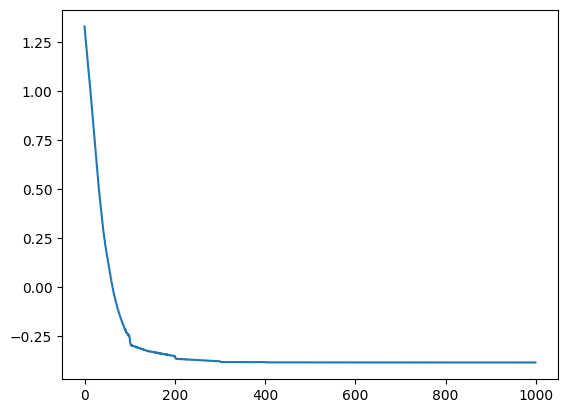

In [10]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [11]:
model_all_linear1_params.reshape(1,-1)

tensor([[-9.8087e-02, -4.6767e-07,  3.4451e-07, -1.4160e-01, -8.8275e-07,
         -8.8662e-07, -1.0593e-02, -1.6899e-06, -9.0899e-07, -2.7724e-06,
          4.1751e-07, -8.1257e-07, -5.3384e-07,  1.5083e-06,  1.1055e-06,
          1.5680e-06,  3.2885e-07, -4.7674e-07,  1.4150e-06, -1.4855e-06,
          1.3867e-06, -3.9065e-07, -1.3880e-06,  9.4952e-07, -1.2281e-06,
         -4.0370e-07, -5.7801e-08, -1.6850e-06, -7.2840e-07,  7.7639e-07,
          1.2351e-06,  4.9367e-08,  1.3207e-06,  2.5136e-07,  7.8394e-07,
         -1.2737e-06, -9.1687e-07,  4.2770e-07, -1.2785e-06, -3.7285e-08,
         -8.9269e-07, -1.5834e-06,  1.5072e-06,  6.0343e-08,  4.4534e-02,
          3.9055e-07, -1.2207e-06, -5.4873e-07, -9.3764e-07,  6.6415e-07,
          4.2334e-07, -1.5100e-06, -7.5972e-07, -8.3293e-07,  6.6688e-07,
          4.4063e-07, -4.6348e-07,  4.6551e-07,  3.0015e-08,  1.6883e-07,
         -9.8362e-07,  1.7812e-07, -1.0458e-06, -8.6960e-07,  1.2424e-06,
         -1.3290e-08, -1.5418e-06,  8.

In [12]:
################## third step ##################
################## testing stage ##################

prediction= (model(test_x)[0]>0.5).clone().int()
target= test_y.reshape(-1,1).int()


prediction=prediction.tolist()
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[34, 25],
       [21, 40]])

0.6557377049180327

0.576271186440678

0.6166666666666667

0.6153846153846154

0.634920634920635

In [14]:
# variable selection evaluation

model_weight=model_all_linear1_params.detach().numpy().copy().reshape(1,-1)


model_weight

array([[-9.8086521e-02, -4.6767298e-07,  3.4450593e-07, -1.4160456e-01,
        -8.8274749e-07, -8.8661739e-07, -1.0593497e-02, -1.6899139e-06,
        -9.0899033e-07, -2.7724359e-06,  4.1751258e-07, -8.1256809e-07,
        -5.3383843e-07,  1.5082560e-06,  1.1054655e-06,  1.5679623e-06,
         3.2884819e-07, -4.7673691e-07,  1.4150274e-06, -1.4855035e-06,
         1.3866705e-06, -3.9065179e-07, -1.3880469e-06,  9.4952185e-07,
        -1.2281116e-06, -4.0370097e-07, -5.7800602e-08, -1.6850204e-06,
        -7.2840459e-07,  7.7639464e-07,  1.2350973e-06,  4.9366530e-08,
         1.3206634e-06,  2.5135787e-07,  7.8393589e-07, -1.2736775e-06,
        -9.1686707e-07,  4.2769747e-07, -1.2784901e-06, -3.7285009e-08,
        -8.9269048e-07, -1.5833507e-06,  1.5072335e-06,  6.0342778e-08,
         4.4534314e-02,  3.9055399e-07, -1.2206544e-06, -5.4872589e-07,
        -9.3764129e-07,  6.6414970e-07,  4.2334182e-07, -1.5100383e-06,
        -7.5971974e-07, -8.3293037e-07,  6.6688153e-07,  4.40633

In [15]:
threshold=0.15
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=model_weight[0,i]

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_weight[0,i]=0
    else:
        model_weight[0,i]=model_weight[0,i]
        
index=np.nonzero(model_weight)[1]
model_weight
final_index=index+1
final_index
len(index)

array([[-0.09808652,  0.        ,  0.        , -0.14160456,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.04453431,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  4, 45])

3

(raylet) [2022-10-03 17:20:20,151 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1459789824; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:20:34,662 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1469734912; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:20:44,670 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1468207104; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:20:54,684 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1467756544; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 17:25:35,029 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1444941824; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:25:45,036 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1444229120; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:25:55,042 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1443397632; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:26:05,058 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1441968128; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 17:30:45,330 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1418805248; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:30:55,338 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1418358784; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:31:05,344 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1417756672; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:31:15,350 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1416990720; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 17:35:55,688 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1393307648; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:36:05,696 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1392328704; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:36:15,703 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1392177152; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:36:25,713 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1391230976; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 17:41:06,012 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1367818240; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:41:16,030 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1366937600; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:41:26,056 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1365938176; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:41:36,073 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1365774336; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 17:46:16,358 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1342078976; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:46:26,369 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1341157376; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:46:36,378 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1340493824; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:46:46,384 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1339428864; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 17:51:26,618 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1320022016; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:51:36,626 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1319940096; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:51:46,635 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1319837696; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:51:56,643 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1319673856; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 17:56:36,906 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1317142528; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:56:46,914 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1317052416; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:56:56,922 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1316900864; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 17:57:06,930 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1316859904; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 18:01:47,166 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1314402304; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:01:57,174 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1314267136; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:02:07,183 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1314201600; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:02:17,192 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1314123776; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 18:06:57,427 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1311649792; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:07:07,435 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1311592448; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:07:17,444 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1311506432; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:07:27,452 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1311465472; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 18:12:07,695 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1309007872; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:12:17,704 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1308921856; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:12:27,713 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1308856320; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:12:37,720 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1308729344; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 18:17:17,959 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1306230784; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:17:27,967 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1306181632; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:17:37,976 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1306050560; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:17:47,985 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1305960448; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 18:22:28,216 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1303490560; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:22:38,224 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1303371776; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:22:48,231 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1303257088; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:22:58,239 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1303175168; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 18:27:38,473 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1300709376; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:27:48,482 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1300611072; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:27:58,490 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1300520960; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:28:08,499 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1300455424; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 18:32:48,735 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1297879040; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:32:58,743 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1297793024; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:33:08,752 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1297735680; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:33:18,761 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1297678336; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 18:37:59,001 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1295138816; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:38:09,009 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1295060992; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:38:19,018 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1294995456; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:38:29,027 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1294946304; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 18:43:09,282 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1292419072; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:43:19,291 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1292353536; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:43:29,299 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1292279808; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:43:39,307 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1292165120; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 18:50:19,674 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1288675328; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:50:29,682 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1288630272; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:50:39,691 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1288491008; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:50:49,699 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1288372224; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 18:55:29,939 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1285992448; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:55:39,947 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1285865472; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:55:49,956 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1285726208; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 18:55:59,964 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1285652480; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 19:00:40,204 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1283231744; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:00:50,213 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1283112960; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:01:00,222 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1283022848; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:01:10,231 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1282957312; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 19:05:50,472 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1280761856; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:06:00,481 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1280692224; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:06:10,489 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1280630784; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:06:20,498 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1280565248; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 19:11:00,733 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1278103552; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:11:10,742 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1278029824; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:11:20,750 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1277960192; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:11:30,759 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1277890560; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 19:16:10,995 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1275228160; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:16:21,004 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1275154432; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:16:31,013 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1275076608; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:16:41,020 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1274957824; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 19:21:21,260 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1272332288; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:21:31,268 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1272258560; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:21:41,276 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1272143872; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:21:51,286 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1271975936; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 19:26:31,521 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1269440512; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:26:41,530 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1269329920; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:26:51,539 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1269186560; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:27:01,548 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1269096448; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 19:31:41,793 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1266552832; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:31:51,802 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1266384896; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:32:01,811 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1266294784; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:32:11,819 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1266241536; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 19:36:52,086 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1263591424; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:37:02,094 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1263513600; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:37:12,102 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1263439872; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:37:22,110 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1263362048; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 19:42:02,347 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1260691456; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:42:12,356 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1260617728; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:42:22,364 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1260548096; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:42:32,373 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1260466176; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 19:47:12,613 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1257889792; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:47:22,621 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1257816064; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:47:32,630 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1257734144; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:47:42,638 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1257619456; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 19:52:22,899 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1255034880; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:52:32,908 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1254973440; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:52:42,917 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1254858752; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:52:52,925 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1254752256; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 19:57:33,163 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1252352000; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:57:43,172 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1252249600; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:57:53,181 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1252114432; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 19:58:03,189 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1252032512; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 20:02:43,431 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1249538048; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:02:53,440 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1249406976; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:03:03,449 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1249333248; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:03:13,457 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1249275904; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 20:07:53,715 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1246760960; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:08:03,724 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1246679040; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:08:13,732 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1246621696; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:08:23,741 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1246531584; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 20:13:03,980 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1244065792; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:13:13,989 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1244008448; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:13:23,997 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1243930624; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:13:34,006 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1243860992; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 20:18:14,245 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1241432064; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:18:24,254 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1241350144; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:18:34,262 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1241300992; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:18:44,271 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1241178112; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 20:23:24,507 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1238753280; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:23:34,516 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1238708224; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:23:44,525 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1238597632; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:23:54,533 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1238446080; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 20:28:34,775 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1235963904; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:28:44,784 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1235853312; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:28:54,793 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1235714048; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:29:04,801 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1235619840; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 20:33:45,039 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1233154048; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:33:55,047 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1232994304; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:34:05,055 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1232904192; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:34:15,064 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1232814080; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 20:38:55,306 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1230266368; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:39:05,315 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1230204928; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:39:15,324 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1230110720; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:39:25,332 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1230061568; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 20:44:05,560 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1227575296; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:44:15,568 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1227505664; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:44:25,577 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1227436032; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:44:35,585 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1227354112; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 20:49:15,829 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1224888320; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:49:25,838 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1224847360; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:49:35,846 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1224761344; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:49:45,855 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1224658944; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 20:54:26,098 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1222180864; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:54:36,107 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1222107136; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:54:46,116 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1222017024; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:54:56,125 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1221894144; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 20:59:36,367 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1219477504; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:59:46,376 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1219366912; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 20:59:56,385 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1219248128; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:00:06,394 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1219186688; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 21:04:46,640 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1216724992; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:04:56,648 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1216589824; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:05:06,656 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1216528384; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:05:16,665 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1216446464; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 21:09:56,906 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1213935616; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:10:06,915 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1213870080; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:10:16,924 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1213788160; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:10:26,932 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1213693952; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 21:15:07,168 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1211133952; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:15:17,177 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1211060224; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:15:27,184 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1211006976; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:15:37,193 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1210900480; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 21:20:17,470 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1208397824; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:20:27,478 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1208348672; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:20:37,487 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1208250368; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:20:47,495 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1208176640; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 21:25:27,733 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1205747712; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:25:37,742 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1205645312; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:25:47,751 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1205551104; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:25:57,759 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1205391360; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 21:30:38,000 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1202999296; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:30:48,008 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1202888704; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:30:58,017 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1202728960; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:31:08,026 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1202679808; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 21:35:48,264 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1200283648; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:35:58,273 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1200144384; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:36:08,282 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1200074752; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:36:18,291 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1200001024; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 21:40:58,534 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1197522944; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:41:08,543 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1197477888; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:41:18,551 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1197387776; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:41:28,560 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1197338624; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 21:46:08,798 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1194868736; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:46:18,806 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1194799104; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:46:28,814 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1194737664; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:46:38,822 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1194614784; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 21:51:19,060 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1192042496; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:51:29,069 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1191989248; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:51:39,077 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1191870464; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:51:49,085 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1191751680; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 21:56:29,325 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1189330944; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:56:39,333 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1189216256; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:56:49,341 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1189117952; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 21:56:59,350 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1189044224; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 22:01:39,593 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1186562048; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:01:49,602 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1186443264; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:01:59,610 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1186344960; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:02:09,619 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1186299904; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 22:06:49,852 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1183797248; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:06:59,861 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1183727616; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:07:09,870 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1183653888; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:07:19,878 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1183576064; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 22:12:00,114 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1181110272; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:12:10,123 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1181052928; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:12:20,131 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1180962816; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:12:30,140 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1180884992; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 22:17:10,377 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1178415104; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:17:20,385 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1178353664; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:17:30,393 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1178296320; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:17:40,402 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1178185728; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 22:22:20,637 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1175744512; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:22:30,645 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1175674880; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:22:40,654 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1175572480; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:22:50,662 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1175441408; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 22:27:30,895 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1173012480; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:27:40,903 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1172897792; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:27:50,911 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1172754432; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:28:00,920 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1172684800; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 22:32:41,151 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1170132992; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:32:51,159 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1169981440; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:33:01,167 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1169899520; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:33:11,174 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1169842176; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 22:37:51,412 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1167228928; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:38:01,419 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1167151104; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:38:11,428 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1167085568; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:38:21,436 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1167011840; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 22:43:01,696 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1157029888; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:43:11,703 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1154920448; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:43:21,710 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1154314240; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:43:31,715 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1153040384; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 22:48:12,036 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1130983424; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:48:22,042 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1129775104; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:48:32,050 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1128837120; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:48:42,060 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1127931904; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 22:53:22,509 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1104916480; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:53:32,517 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1104289792; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:53:42,524 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1102553088; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:53:52,547 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1101709312; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 22:58:32,824 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1078652928; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:58:42,837 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1077944320; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:58:52,843 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1077301248; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 22:59:02,849 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1075548160; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 23:03:43,114 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1052667904; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:03:53,121 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1051648000; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:04:03,129 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1051004928; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:04:13,134 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1050460160; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 23:08:53,440 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1026617344; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:09:03,452 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1026011136; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:09:13,460 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1024802816; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:09:23,471 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1023901696; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 23:14:03,818 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1000431616; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:14:13,825 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 999710720; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:14:23,833 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 999067648; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:14:33,843 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 998273024; capacity: 29394726912. Object creation will fail 

(raylet) [2022-10-03 23:19:14,177 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 974135296; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:19:24,186 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 973590528; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:19:34,200 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 972787712; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:19:44,215 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 972034048; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-03 23:24:24,588 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1018126336; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:24:34,597 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1017774080; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:24:44,611 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1016918016; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:24:54,620 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 1016025088; capacity: 29394726912. Object creation will fa

(raylet) [2022-10-03 23:29:34,851 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 983904256; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:29:44,857 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 982835200; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:29:54,864 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 982257664; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:30:04,870 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 981606400; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-03 23:34:45,203 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 958078976; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:34:55,210 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 957202432; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:35:05,222 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 956137472; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:35:15,229 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 955760640; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-03 23:39:55,529 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 933097472; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:40:05,542 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 931192832; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:40:15,549 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 931024896; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:40:25,557 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 929239040; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-03 23:45:05,845 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 906936320; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:45:15,850 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 906485760; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:45:25,855 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 904925184; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:45:35,863 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 904556544; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-03 23:50:16,186 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 880959488; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:50:26,199 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 880590848; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:50:36,205 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 879935488; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:50:46,211 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 878407680; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-03 23:55:26,512 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 855453696; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:55:36,560 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 854528000; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:55:46,587 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 853970944; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-03 23:55:56,605 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 853073920; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-04 00:00:36,856 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 830009344; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-04 00:00:46,862 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 829259776; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-04 00:00:56,875 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 828493824; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-04 00:01:06,885 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 827838464; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-04 00:05:47,268 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 804659200; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-04 00:05:57,286 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 803627008; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-04 00:06:07,304 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 802553856; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-04 00:06:17,328 E 13430 13448] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-03_16-16-45_700808_13311 is over 95% full, available space: 801906688; capacity: 29394726912. Object creation will fail i